In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, bartlett, ttest_ind, ks_2samp, mannwhitneyu

sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-."})

In [2]:
os.makedirs('../images', exist_ok=True)

In [ ]:
def create_data():
    """
    Cria e retorna uma lista de tuplas contendo os DataFrames e seus respectivos rótulos.
    """   
    return [
        # (df1, "air mines (baseline)"),
        # (df2, "without communication"),
        (pd.read_csv('../data/centralized/results_2025_05_02_09h14m49s.csv'), "centralized"),
        # (df3, "proposal"),
        # (df4, "proposal_spread"),
        (pd.read_csv('../data/proposal_aew/results_2025_05_02_20h09m19s.csv'), "proposal_aew"),
        (pd.read_csv('../data/proposal_aew_spread/results_2025_05_02_13h06m30s.csv'), "proposal_aew_spread")
    ]
    
    

In [4]:
dataframes = create_data()

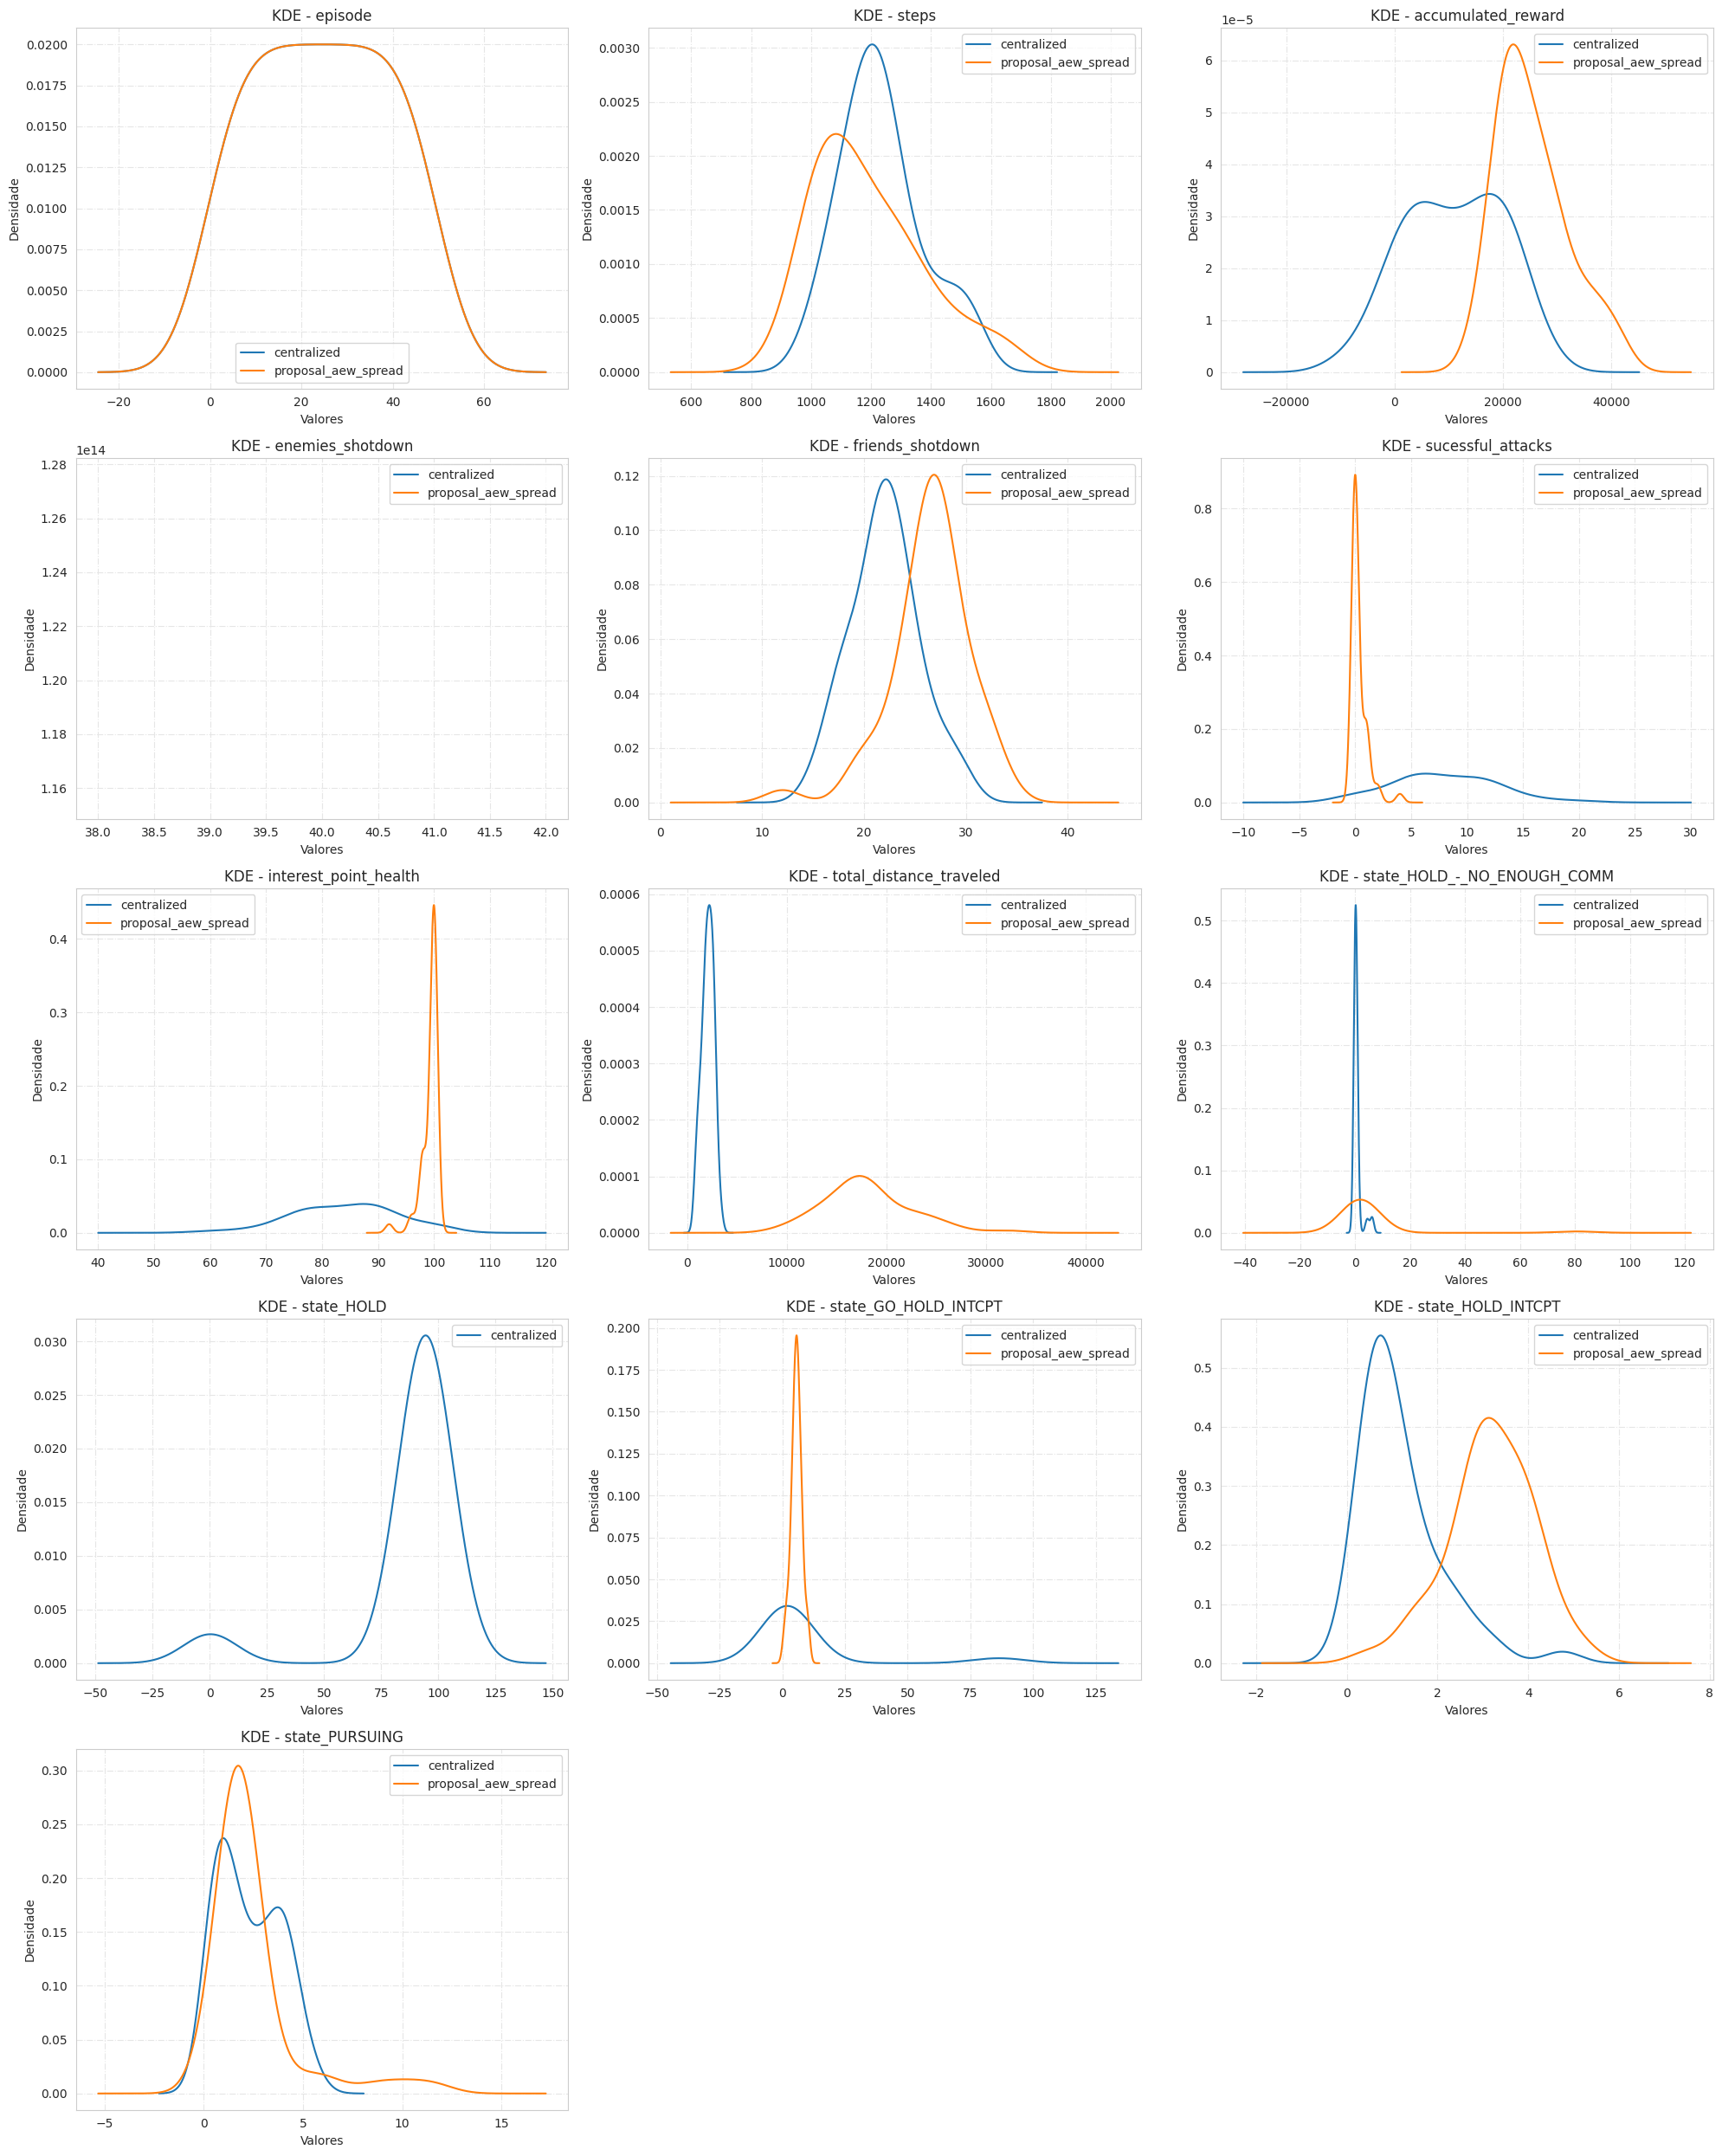

In [5]:
import matplotlib.pyplot as plt
import math

# Lista de índices disponíveis
indices = range(len(dataframes))

# Assume que todos os dataframes possuem as mesmas colunas e pega as colunas do primeiro
columns = dataframes[0][0].columns
num_columns = len(columns)

# Calcula o número de linhas necessárias para 3 subplots por linha
num_rows = math.ceil(num_columns / 3)

# Cria a figura e os eixos com o grid configurado
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5 * num_rows))

# Caso haja apenas uma linha ou apenas um subplot, garante que axes seja uma lista
if num_rows == 1:
    axes = axes.flatten()
else:
    axes = [ax for row in axes for ax in row]

# Plota as curvas KDE para cada coluna e para cada dataframe
for i, col in enumerate(columns):
    ax = axes[i]
    for idx in indices:
        df = dataframes[idx][0]
        label = dataframes[idx][1]  # Utiliza o elemento da tupla como label
        if col in df.columns:
            # df[col].plot(ax=ax, label=label)
            df[col].plot(kind='kde', ax=ax, label=label)
    ax.set_title(f'KDE - {col}')
    ax.set_xlabel('Valores')
    ax.set_ylabel('Densidade')
    ax.legend()

# Oculta subplots vazios, se houver
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
def plot_kde_overlaid_with_ci(data_list, column='accumulated_reward'):
    """
    Plots overlaid KDEs for a list of datasets containing the 'accumulated_reward' information.
    It also adds the 95% confidence interval for the mean of each distribution.
    
    Parameters:
      data_list : list of tuples
          Each tuple should be (df, label) where df is a DataFrame or Series containing
          the data for the specified column, and label is a string for the legend.
      column : str, optional
          The column to plot (default is 'accumulated_reward').
    """
    
    # Create a new figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define a list of colors and linestyles to cycle through (if more datasets than colors, they will repeat)
    # colors = sns.color_palette("pastel", len(data_list))
    colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
    
    # Iterate over each dataset in the provided list
    for idx, (df, label) in enumerate(data_list):
        # Ensure the provided data for the column is in DataFrame format.
        # If the column is a Series, convert it into a DataFrame.
        if not isinstance(df, pd.DataFrame):
            df = pd.DataFrame(df, columns=[column])
        elif column not in df.columns:
            raise ValueError(f"The dataset '{label}' does not contain the column '{column}'.")
        
        # Choose a color and linestyle for the current dataset
        color = colors[idx % len(colors)]
    
                
        # Plot the KDE for the current dataset
        sns.kdeplot(
            data=df, 
            x=column, 
            label=label, 
            fill=True, 
            alpha=0.3, 
            linewidth=0.5, 
            color=color, 
            linestyle='-', 
            ax=ax
        )
        
        # Get the rewards data and drop any NaNs
        rewards = df[column].dropna()
        n = len(rewards)
        if n < 2:
            print(f"Warning: The dataset '{label}' has less than 2 points. Cannot compute CI.")
            continue
        
        # Calculate the mean, standard error, and the 95% confidence interval
        mean = rewards.mean()
        sem = stats.sem(rewards)
        ci_mult = stats.t.ppf(0.975, df=n-1)
        ci_lower, ci_upper = mean - ci_mult * sem, mean + ci_mult * sem
        
        # Plot a vertical line for the mean
        ax.axvline(mean, color=color, linestyle="-", linewidth=2, alpha=0.3,
                   label=f"Mean ({label}): {mean:.2f}")
        # # Plot the confidence interval as a shaded area
        # ax.axvspan(ci_lower, ci_upper, color=color, alpha=0.2,
        #            label=f"95% CI ({label})")
    
    # Set labels, title, and legend
    ax.set_xlabel("Accumulated Reward")
    ax.set_ylabel("Density")
    ax.set_title("Kernel Density Estimation with 95% Confidence Intervals", fontsize=10, fontweight='bold')
    ax.legend(loc='upper right')
    
    # Optionally, set x-axis limits if needed (adjust as required)
    # ax.set_xlim(-1000, 20000)
    
    plt.tight_layout()
    plt.savefig('../images/kde_ci_combined.png', format='png')
    plt.show()
    plt.close()


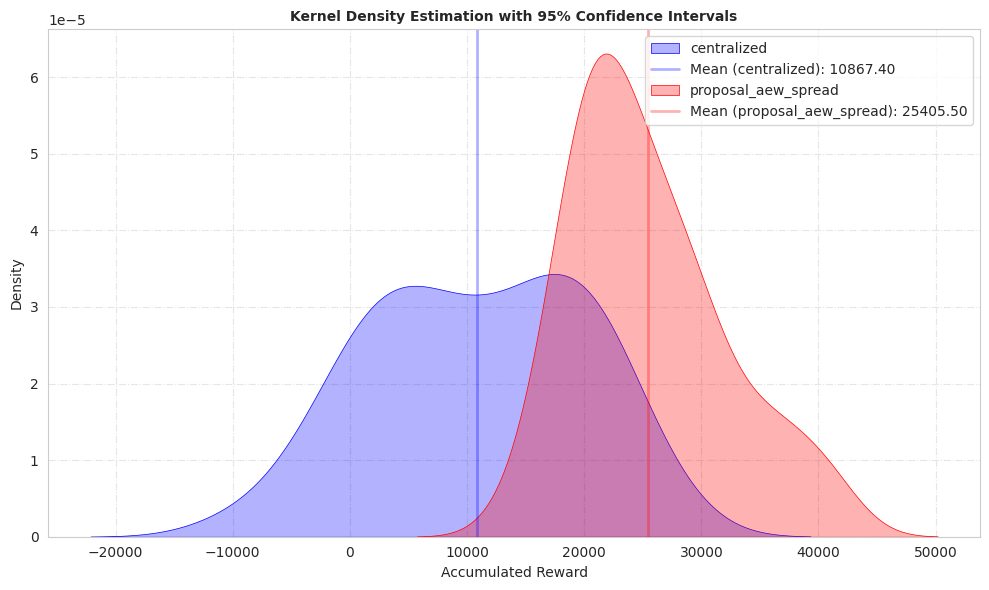

In [7]:
plot_kde_overlaid_with_ci(dataframes)

In [8]:

def plot_hist_kde_ci(data, color='b', column='accumulated_reward'):
    """
    Plots overlaid KDEs for a list of datasets containing the 'accumulated_reward' information.
    It also adds the 95% confidence interval for the mean of each distribution.
    
    Parameters:
      data_list : list of tuples
          Each tuple should be (df, label) where df is a DataFrame or Series containing
          the data for the specified column, and label is a string for the legend.
      column : str, optional
          The column to plot (default is 'accumulated_reward').
    """
    
    df, label = data
    
    # Create a new figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define a list of colors and linestyles to cycle through (if more datasets than colors, they will repeat)
    # colors = sns.color_palette("pastel", len(data_list))
    
    # Ensure the provided data for the column is in DataFrame format.
    # If the column is a Series, convert it into a DataFrame.
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df, columns=[column])
    elif column not in df.columns:
        raise ValueError(f"The dataset '{label}' does not contain the column '{column}'.")
    
    
    # Plot o histograma para o dataset
    sns.histplot(
        data=df, 
        x=column, 
        color=color, 
        alpha=0.3, 
        stat="density", 
        bins=25, 
        ax=ax
    )
    
    # Plot the KDE for the current dataset
    sns.kdeplot(
        data=df, 
        x=column, 
        label=label, 
        fill=True, 
        alpha=0.3, 
        linewidth=0.5, 
        color=color, 
        linestyle='-', 
        ax=ax
    )
    
    # Get the rewards data and drop any NaNs
    rewards = df[column].dropna()
    n = len(rewards)
    if n < 2:
        return
    
    # Calculate the mean, standard error, and the 95% confidence interval
    mean = rewards.mean()
    sem = stats.sem(rewards)
    ci_mult = stats.t.ppf(0.975, df=n-1)
    ci_lower, ci_upper = mean - ci_mult * sem, mean + ci_mult * sem
    
    # Plot a vertical line for the mean
    ax.axvline(mean, color=color, linestyle=":", linewidth=2,
                label=f"Mean ({label}): {mean:.2f}")
    # Plot the confidence interval as a shaded area
    ax.axvspan(ci_lower, ci_upper, color=color, alpha=0.08,
                label=f"95% CI ({label})")
    
    # Set labels, title, and legend
    ax.set_xlabel("Accumulated Reward")
    ax.set_ylabel("Density")
    ax.set_title("Kernel Density Estimation with 95% Confidence Intervals", fontsize=10, fontweight='bold')
    ax.legend(loc='upper right')
    
    # Optionally, set x-axis limits if needed (adjust as required)
    # ax.set_xlim(-1000, 6000)
    
    plt.tight_layout()
    plt.savefig('../images/hist.png', format='png')
    plt.show()
    plt.close()


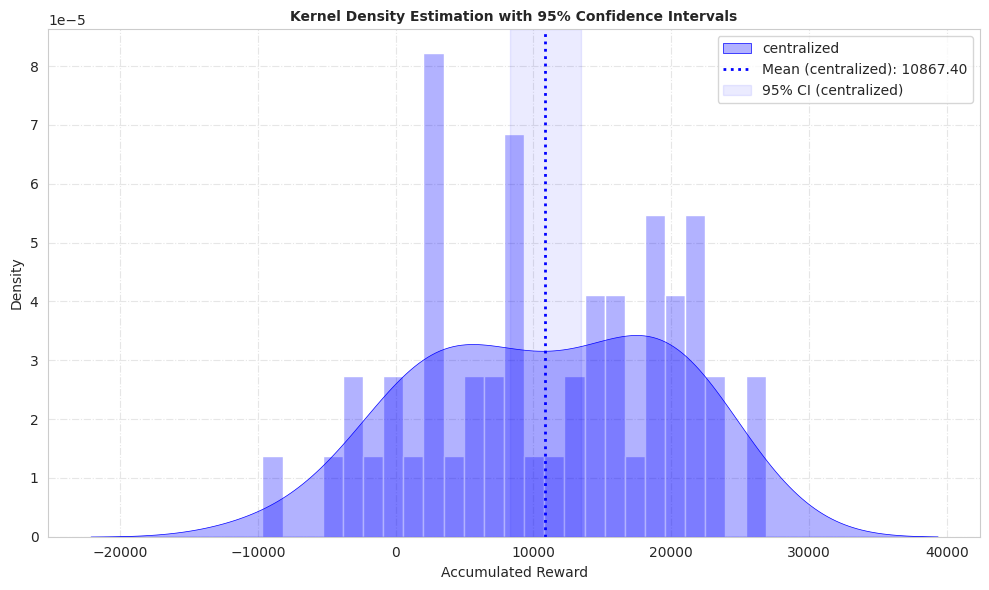

In [9]:
plot_hist_kde_ci(dataframes[0], 'b')

In [10]:
# plot_hist_kde_ci(dataframes[1], 'r')

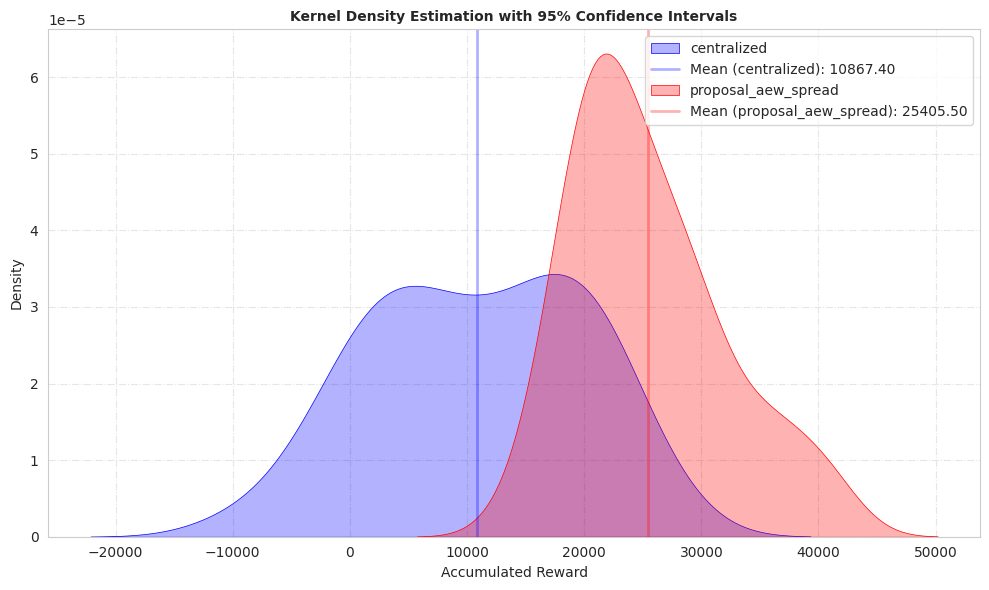

In [11]:
plot_kde_overlaid_with_ci(dataframes)  

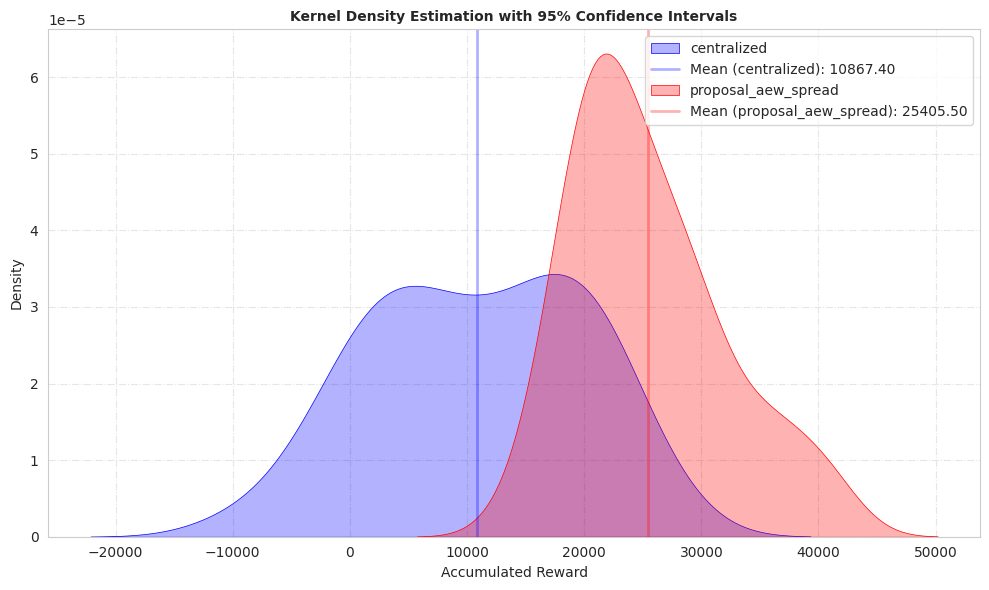

In [12]:
for i in range(len(dataframes)):
    for j in range(i + 1, len(dataframes)):
        data_a = dataframes[i]
        data_b = dataframes[j]
        plot_kde_overlaid_with_ci([data_a, data_b])  

In [13]:
# def plot_shapiro_wilk(data, column='accumulated_reward'):
#     """
#     Realiza o teste de Shapiro-Wilk e plota o QQ Plot com a legenda e o parecer técnico abaixo do gráfico.
#     """
#     df, label = data
#     W, p = shapiro(df[column])
    
#     fig, ax = plt.subplots(figsize=(10, 6))
#     stats.probplot(df[column], dist="norm", plot=ax)
#     ax.set_title(f'[{label}] QQ Plot', fontsize=10, fontweight='bold')
#     # Adiciona um item dummy à legenda com o resultado do teste
#     dummy_line, = ax.plot([], [], ' ', label=f"Shapiro-Wilk: W={W:.3f}, p={p:.3f}")
#     ax.legend(loc='lower right')
#     if p > 0.05:
#         parecer = (f"Não rejeitamos H0 de normalidade.\n"
#                    "sugerindo que os dados se comportam como provenientes de uma distribuição normal.")
#     else:
#         parecer = (f"Rejeitamos H0 de normalidade.\n"
#                    "indicando que os dados NÃO se comportam como provenientes de uma distribuição normal.")
#     plt.figtext(0.5, 0.02, parecer, ha="center", fontsize=10,
#                 bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})
#     plt.tight_layout(rect=[0, 0.15, 1, 1])
#     plt.savefig(f'../images/qqplot_{label}.png', format='png')
#     plt.show()
#     plt.close()

def plot_shapiro_wilk(data, column='accumulated_reward'):
    """
    Realiza o teste de Shapiro-Wilk e plota o QQ Plot com a legenda e o parecer técnico abaixo do gráfico.
    """
    df, label = data
    W, p = shapiro(df[column])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    stats.probplot(df[column], dist="norm", plot=ax)
    ax.set_title(f'[{label}] QQ Plot', fontsize=10, fontweight='bold')
    # Adiciona um item dummy à legenda com o resultado do teste
    dummy_line, = ax.plot([], [], ' ', label=f"Shapiro-Wilk: W={W:.3f}, p={p:.3f}")
    ax.legend(loc='lower right')
    
    # Define o parecer e a cor do box conforme o resultado do teste
    if p > 0.05:
        parecer = ("Não rejeitamos H0 de normalidade.\n"
                   "Sugerindo que os dados se comportam como provenientes de uma distribuição normal.")
        box_color = "lightgreen"
    else:
        parecer = ("Rejeitamos H0 de normalidade.\n"
                   "Indicando que os dados NÃO se comportam como provenientes de uma distribuição normal.")
        box_color = "lightcoral"
    
    plt.figtext(0.5, 0.02, parecer, ha="center", fontsize=10,
                bbox={"facecolor": box_color, "alpha": 0.5, "pad": 5})
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.savefig(f'../images/qqplot_{label}.png', format='png')
    plt.show()
    plt.close()

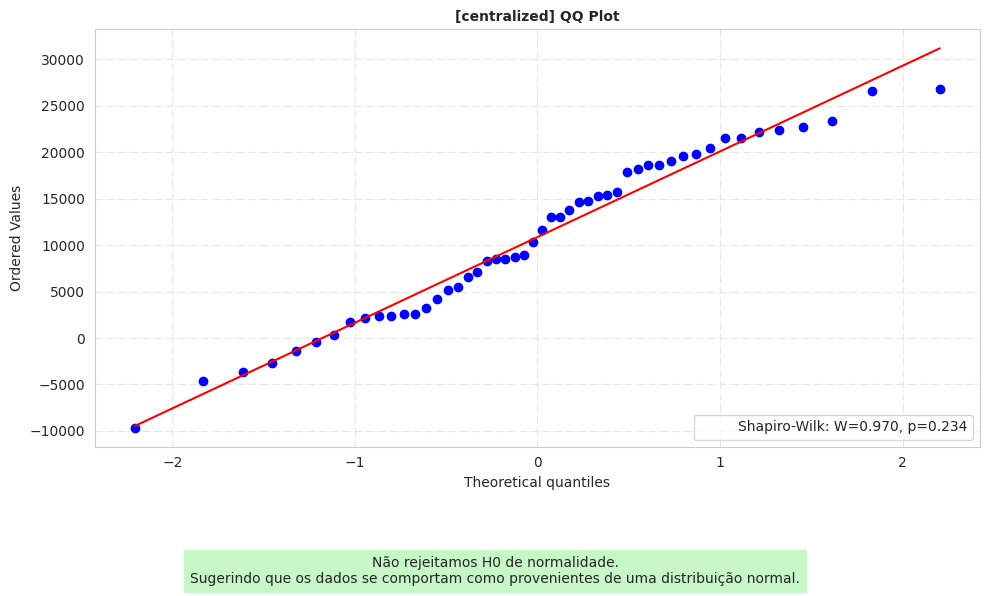

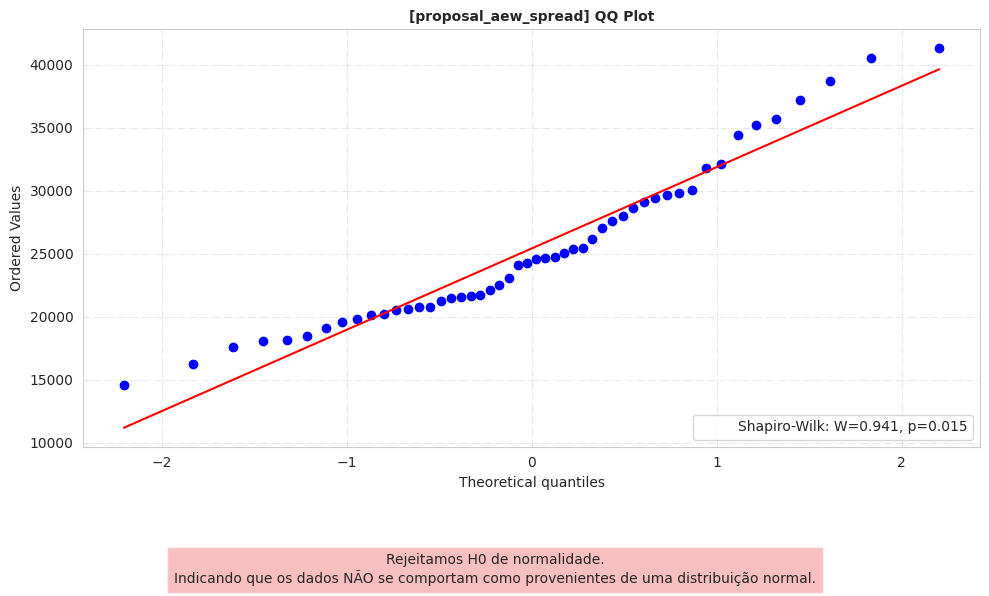

In [14]:
for i in range(len(dataframes)):
    data = dataframes[i]
    plot_shapiro_wilk(data) 

### Se as amostras forem normais, é possível utilizar testes paramétricos que comparam diretamente os parâmetros da distribuição (média e variância). Por exemplo:

- ##### Teste de Bartlett: Para comparar as variâncias entre as amostras.
- ##### Teste t de Student: Para comparar as médias de duas amostras (assumindo variâncias iguais).
- ##### Teste t de Welcht: Para comparar as médias de duas amostras (assumindo variâncias diferentes).

##### Esses testes aproveitam a hipótese de normalidade para serem mais poderosos do que os testes não paramétricos, desde que os pressupostos sejam atendidos.

In [15]:
# homogeneidade das variâncias
def plot_bartlett(data_a, data_b, column='accumulated_reward'):

    df_a, label_a = data_a
    df_b, label_b = data_b
    
    # Verifica se a coluna existe em ambos os DataFrames
    if column not in df_a.columns or column not in df_b.columns:
        raise ValueError(f"A coluna '{column}' não está presente em ambos os DataFrames.")
    
    # Realiza o teste de Bartlett
    bart_stat, bart_p = bartlett(df_a[column], df_b[column])
    print(f"{label_a} vs {label_b}: estatística = {bart_stat:.4f}, p-value = {bart_p:.4f}")
    
    # Calcula as variâncias
    var_a = df_a[column].var(ddof=1)
    var_b = df_b[column].var(ddof=1)
    
    # Cria o boxplot
    fig, ax = plt.subplots(figsize=(10, 6))
    data_box = [df_a[column], df_b[column]]
    sns.boxplot(data=data_box, ax=ax, palette=['b', 'r'])
    ax.set_title("Intuição do Teste de Bartlett - Boxplots dos Grupos", fontsize=10)
    ax.set_xlabel("Grupo")
    ax.set_ylabel(column)
    ax.set_xticklabels([label_a, label_b])
    
    # Anota as variâncias próximas aos respectivos boxplots
    ylim = ax.get_ylim()
    ax.annotate(f"Var = {var_a:.1f}", xy=(0, ylim[1]*0.9), xycoords='data',
                ha='center', color='b', fontsize=10)
    ax.annotate(f"Var = {var_b:.1f}", xy=(1, ylim[1]*0.9), xycoords='data',
                ha='center', color='r', fontsize=10)
    
    # Interpretação do teste
    if bart_p > 0.05:
        parecer_bartlett = ("Não rejeitamos H0 de homogeneidade das variâncias; "
                            "os dados sugerem variâncias homogêneas.")
    else:
        parecer_bartlett = ("Rejeitamos H0 de homogeneidade das variâncias; "
                            "as variâncias dos grupos são significativamente diferentes.")
    
    # Exibe o resultado do teste e o parecer técnico abaixo do gráfico
    plt.figtext(0.5, 0.01, f"Bartlett Test: estatística = {bart_stat:.2f}, p-value = {bart_p:.3f}\n{parecer_bartlett}",
                ha="center", fontsize=10,
                bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f'../images/bartlett_{label_a}_{label_b}.png', format='png')
    plt.show()
    plt.close()

In [16]:
# for i in range(len(dataframes)):
#     for j in range(i + 1, len(dataframes)):
#         data_a = dataframes[i]
#         data_b = dataframes[j]
#         plot_bartlett(data_a, data_b)  

In [17]:
# homogeneidade das médias
def plot_t_student(data_a, data_b, column='accumulated_reward'):
    df_a, label_a = data_a
    df_b, label_b = data_b

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df_a, x='accumulated_reward', label=label_a, fill=True, alpha=0.5,
                color='b', linewidth=2, ax=ax)
    sns.kdeplot(data=df_b, x='accumulated_reward', label=label_b, fill=True, alpha=0.5,
                color='r', linewidth=2, ax=ax)
    
    mean_a = df_a['accumulated_reward'].mean()
    mean_b = df_b['accumulated_reward'].mean()
    ci_a = 1.96 * df_a['accumulated_reward'].std(ddof=1) / np.sqrt(len(df_a))
    ci_b = 1.96 * df_b['accumulated_reward'].std(ddof=1) / np.sqrt(len(df_b))
    ax.axvline(mean_a, color='b', linestyle='--', label=f"{label_a} Mean = {mean_a:.2f}")
    ax.axvline(mean_b, color='r', linestyle='--', label=f"{label_b} Mean = {mean_b:.2f}")
    ylim = ax.get_ylim()
    y_vals = np.linspace(ylim[0], ylim[1], 100)
    ax.fill_betweenx(y_vals, mean_a - ci_a, mean_a + ci_a, color='b', alpha=0.2, label=f"{label_a} 95% CI")
    ax.fill_betweenx(y_vals, mean_b - ci_b, mean_b + ci_b, color='r', alpha=0.2, label=f"{label_b} 95% CI")
    t_stat, t_p = ttest_ind(df_a['accumulated_reward'], df_b['accumulated_reward'], equal_var=True)
    ax.set_title(f"Intuição do Teste t de Student\n{label_a} vs {label_b}: t = {t_stat:.2f}, p = {t_p:.3f}", fontsize=10)
    ax.set_xlabel('Accumulated Reward')
    ax.set_ylabel('Densidade')
    ax.legend(loc='upper right')
    ax.set_xlim(0, 4000)
    
    if t_p > 0.05:
        parecer_t = ("Não rejeitamos H0; NÃO há evidências estatísticas suficientes para afirmar que "
                     "as médias dos grupos são significativamente diferentes.")
    else:
        parecer_t = ("Rejeitamos H0; as diferenças nas médias dos grupos são estatisticamente significativas.")
        
    plt.figtext(0.5, 0.01, parecer_t, ha="center", fontsize=10, bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f'../images/t_student_{label_a}_{label_b}.png', format='png')
    plt.show()
    plt.close()

In [18]:
# for i in range(len(dataframes)):
#     for j in range(i + 1, len(dataframes)):
#         data_a = dataframes[i]
#         data_b = dataframes[j]
#         plot_t_student(data_a, data_b)  

In [19]:
def plot_t_welch(data_a, data_b, column='accumulated_reward'):
    
    df_a, label_a = data_a
    df_b, label_b = data_b

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=df_a, x=column, label=label_a, fill=True, alpha=0.5,
                color='r', linewidth=2, ax=ax)
    sns.kdeplot(data=df_b, x=column, label=label_b, fill=True, alpha=0.5,
                color='g', linewidth=2, ax=ax)
    mean_a = df_a[column].mean()
    mean_b = df_b[column].mean()
    ci_a = 1.96 * df_a[column].std(ddof=1) / np.sqrt(len(df_a))
    ci_b = 1.96 * df_b[column].std(ddof=1) / np.sqrt(len(df_b))
    ax.axvline(mean_a, color='r', linestyle='--', label=f"{label_a} Mean = {mean_a:.2f}")
    ax.axvline(mean_b, color='g', linestyle='--', label=f"{label_b} Mean = {mean_b:.2f}")
    ylim = ax.get_ylim()
    y_vals = np.linspace(ylim[0], ylim[1], 100)
    ax.fill_betweenx(y_vals, mean_a - ci_a, mean_a + ci_a, color='r', alpha=0.2, label=f"{label_a} 95% CI")
    ax.fill_betweenx(y_vals, mean_b - ci_b, mean_b + ci_b, color='g', alpha=0.2, label=f"{label_b} 95% CI")
    t_stat, t_p = ttest_ind(df_a[column], df_b[column], equal_var=False)
    ax.set_title(f"Intuição do Teste t de Welch\n{label_a} vs {label_b}: t = {t_stat:.2f}, p = {t_p:.3f}", fontsize=10)
    ax.set_xlabel('Accumulated Reward')
    ax.set_ylabel('Densidade')
    ax.legend(loc='upper right')
    if t_p > 0.05:
        parecer_welch = ("Não rejeitamos H0; não há evidências estatísticas suficientes para afirmar que "
                          "as médias dos grupos são significativamente diferentes, mesmo considerando variâncias desiguais.")
    else:
        parecer_welch = ("Rejeitamos H0; as diferenças nas médias dos grupos são estatisticamente significativas, "
                          "mesmo considerando variâncias desiguais.")
    plt.figtext(0.5, 0.01, parecer_welch, ha="center", fontsize=10,
                bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f'../images/t_welch_{label_a}_{label_b}.png', format='png')
    plt.show()
    plt.close()

In [20]:
# for i in range(len(dataframes)):
#     for j in range(i + 1, len(dataframes)):
#         data_a = dataframes[i]
#         data_b = dataframes[j]
#         plot_t_welch(data_a, data_b)  

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

def plot_anova_mult(data_list, column='accumulated_reward'):
    """
    Realiza o teste de ANOVA para comparar as médias de múltiplas amostras e gera um gráfico
    com boxplots e pontos individuais, além de exibir um parecer técnico sobre a significância
    da diferença entre as médias.
    
    Parâmetros:
    - data_list: lista de tuplas no formato [(df_a, label_a), (df_b, label_b), ...]
    - column: nome da coluna de interesse nos dataframes
    """
    # Extrai os dados e os labels de cada grupo
    values_list = []
    labels = []
    for df, label in data_list:
        values = df[column].values
        values_list.append(values)
        labels.append(label)
    
    # Executa o teste ANOVA (one-way) para todos os grupos
    F_stat, p = f_oneway(*values_list)
    
    # Cria o gráfico com boxplots
    fig, ax = plt.subplots(figsize=(10, 6))
    box = ax.boxplot(values_list, tick_labels=labels, patch_artist=True, medianprops={'color': 'black'})
    
    # Personaliza as cores dos boxplots usando um mapa de cores
    colors = plt.cm.viridis(np.linspace(0, 1, len(values_list)))
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    # Adiciona os pontos individuais com um leve jitter para melhor visualização
    for i, values in enumerate(values_list, start=1):
        jitter = np.random.normal(0, 0.04, size=len(values))
        ax.scatter(np.ones_like(values)*i + jitter, values, alpha=0.7, color='black', s=20)
    
    ax.set_xlabel("Grupo")
    ax.set_ylabel(column)
    title_text = f"ANOVA - {' vs. '.join(labels)}\nF = {F_stat:.3f}, p = {p:.3f}"
    ax.set_title(title_text, fontsize=10, fontweight='bold')
    
    # Cria uma legenda customizada para identificar os grupos
    custom_lines = [plt.Line2D([0], [0], color='black', marker='s', linestyle='',
                                 markersize=10, markerfacecolor=color) for color in colors]
    leg = ax.legend(custom_lines, labels, loc='upper right')
    frame = leg.get_frame()
    frame.set_facecolor('lightgrey')
    frame.set_alpha(0.8)
    
    # Parecer técnico estatístico
    if p > 0.05:
        parecer = ("Não rejeitamos H0; não há evidências estatísticas suficientes para concluir\n"
                   "que as médias dos grupos são significativamente diferentes.")
    else:
        parecer = ("Rejeitamos H0; as médias dos grupos são significativamente diferentes.")
    
    plt.figtext(0.5, 0.02, parecer, ha="center", fontsize=10,
                bbox={"facecolor": "lightgrey", "alpha": 0.5, "pad": 5})
    
    plt.tight_layout(rect=[0, 0.10, 1, 0.95])
    plt.savefig(f'../images/anova_{"_".join(labels)}.png', format='png')
    plt.show()
    plt.close()


In [22]:
# plot_anova_mult(dataframes)

#### Se as amostras não forem normais:

##### O teste mais comumente utilizado para esse fim é o teste de Kolmogorov-Smirnov de duas amostras (KS test). Ele é um teste não paramétrico que compara as funções de distribuição empírica das amostras e testa a hipótese nula de que ambas provêm da mesma distribuição.

##### Para comparar medianas, pode-se utilizar o teste de Mann-Whitney (ou U de Mann-Whitney), que é um teste não paramétrico que compara as distribuições das amostras e testa a hipótese nula de que as medianas são iguais.

In [23]:
def plot_ks_test(data_a, data_b, column='accumulated_reward'):
    
    df_a, label_a = data_a
    df_b, label_b = data_b

    # Ordena os dados e calcula as ECDFs
    data1_sorted = np.sort(df_a[column])
    data2_sorted = np.sort(df_b[column])
    n1, n2 = len(df_a[column]), len(df_b[column])
    # Gera uma grade com a união dos valores das duas amostras
    x = np.sort(np.concatenate((df_a[column], df_b[column])))
    # Calcula as ECDFs usando a contagem dos elementos
    cdf1 = np.searchsorted(data1_sorted, x, side='right') / n1
    cdf2 = np.searchsorted(data2_sorted, x, side='right') / n2

    # Calcula a diferença absoluta entre as ECDFs e encontra o máximo
    diff = np.abs(cdf1 - cdf2)
    ks_stat = diff.max()
    
    # Realiza o teste KS utilizando a função do scipy
    stat, p = ks_2samp(df_a[column], df_b[column])

    # Cria o gráfico
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.step(x, cdf1, label=label_a, where='post', color='b')
    ax.step(x, cdf2, label=label_b, where='post', color='r')
    ax.set_xlabel("Valor")
    ax.set_ylabel("Função de Distribuição Acumulada (FDA)")
    ax.set_title(f"[{label_a} vs. {label_b}] Teste de Kolmogorov-Smirnov (KS test)", fontsize=10, fontweight='bold')
    
    # Encontra o ponto onde ocorre a diferença máxima e plota uma linha vertical para destacá-lo
    idx = np.argmax(diff)
    x_max = x[idx]
    ax.vlines(x_max, cdf1[idx], cdf2[idx], color='k', linestyle='--', 
              label=f"KS stat = {ks_stat:.3f} (p-value = {p:.3f})")
    
    # A legenda do gráfico terá sempre o fundo cinza claro
    leg = ax.legend(loc='lower right')
    frame = leg.get_frame()
    frame.set_facecolor('lightgrey')
    frame.set_alpha(1)
    
    ax.set_xlim(0, 4000)
    
    # Monta o parecer técnico estatístico e define a cor do box do figtext conforme o resultado do teste
    if p > 0.05:
        parecer = ("Não rejeitamos H0\nnão há evidências estatísticas suficientes para concluir "
                    "que as amostras provêm de distribuições diferentes.")
        box_color = "lightgreen"
    else:
        parecer = ("Rejeitamos H0\nHá evidências estatísticas suficientes para concluir "
                    "que as amostras provêm de distribuições diferentes.")
        box_color = "lightcoral"
    
    plt.figtext(0.5, 0.05, parecer, ha="center", fontsize=10, 
                bbox={"facecolor": box_color, "alpha": 0.7, "pad": 5})
    
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.savefig(f'../images/ks_test_{label_a}_{label_b}.png', format='png')
    plt.show()
    plt.close()


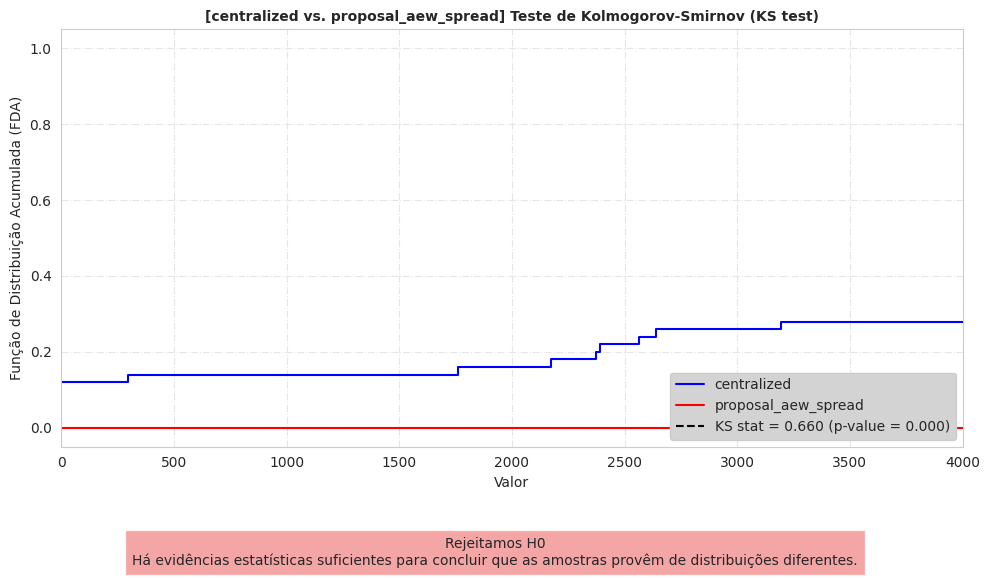

In [24]:
for i in range(len(dataframes)):
    for j in range(i + 1, len(dataframes)):
        data_a = dataframes[i]
        data_b = dataframes[j]
        plot_ks_test(data_a, data_b)  

In [25]:
def plot_mann_whitney(data_a, data_b, column='accumulated_reward'):
    df_a, label_a = data_a
    df_b, label_b = data_b
    
    # Ordena os dados e calcula as ECDFs
    data1_sorted = np.sort(df_a[column])
    data2_sorted = np.sort(df_b[column])
    n1, n2 = len(df_a[column]), len(df_b[column])
    # Gera uma grade com a união dos valores das duas amostras
    x = np.sort(np.concatenate((df_a[column], df_b[column])))
    # Calcula as ECDFs usando a contagem dos elementos
    cdf1 = np.searchsorted(data1_sorted, x, side='right') / n1
    cdf2 = np.searchsorted(data2_sorted, x, side='right') / n2

    # Calcula as medianas de cada amostra
    median1 = np.median(df_a[column])
    median2 = np.median(df_b[column])

    # Realiza o teste de Mann‑Whitney (teste não paramétrico para comparar medianas)
    stat, p = mannwhitneyu(df_a[column], df_b[column], alternative='two-sided')

    # Cria o gráfico
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(x, cdf1, label=label_a, where='post', color='b')
    ax.step(x, cdf2, label=label_b, where='post', color='r')
    # Marca as medianas com linhas tracejadas
    ax.axvline(median1, color='b', linestyle='--', 
               label=f"{label_a} mediana = {median1:.2f}")
    ax.axvline(median2, color='r', linestyle='--', 
               label=f"{label_b} mediana = {median2:.2f}")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Função de Distribuição Acumulada (FDA)")
    ax.set_title(f"[{label_a} vs. {label_b}] Teste de Mann‑Whitney", fontsize=10, fontweight='bold')
    leg = ax.legend(loc='lower right')
    # A legenda do gráfico terá sempre o fundo cinza claro
    frame = leg.get_frame()
    frame.set_facecolor('lightgrey')
    frame.set_alpha(1)
    ax.set_xlim(0, 4000)

    # Define o parecer técnico e a cor do box de acordo com o resultado do teste
    if p > 0.05:
        parecer = ("Não rejeitamos H0; não há evidências estatísticas suficientes para concluir\n"
                   "que as medianas das amostras são significativamente diferentes.")
        box_color = "lightgreen"
    else:
        parecer = ("Rejeitamos H0; as medianas das amostras são significativamente diferentes.")
        box_color = "lightcoral"
    
    plt.figtext(0.5, 0.02, parecer, ha="center", fontsize=10,
                bbox={"facecolor": box_color, "alpha": 0.5, "pad": 5})
    
    plt.tight_layout(rect=[0, 0.10, 1, 1])
    plt.savefig(f'../images/mann_whitney_{label_a}_{label_b}.png', format='png')
    plt.show()
    plt.close()


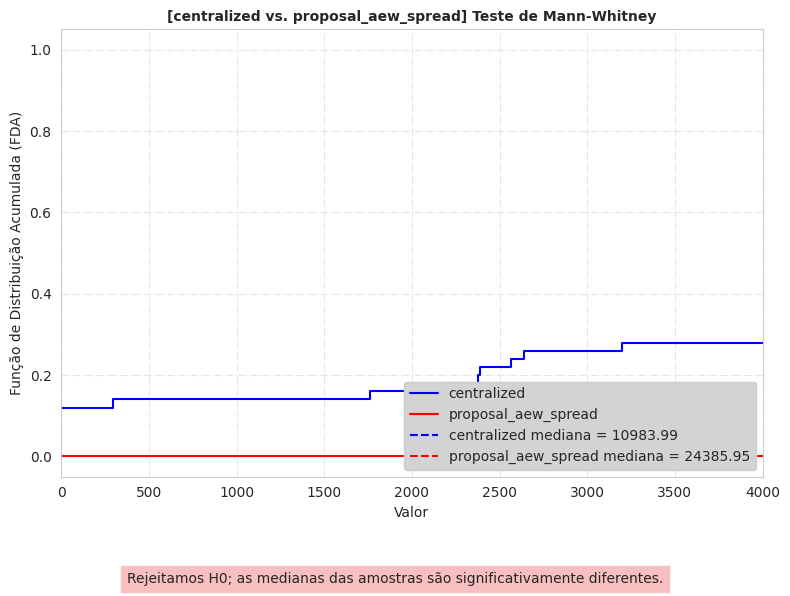

In [26]:
for i in range(len(dataframes)):
    for j in range(i + 1, len(dataframes)):
        data_a = dataframes[i]
        data_b = dataframes[j]
        plot_mann_whitney(data_a, data_b)  

In [27]:
def plot_bootstrap(data_a, data_b, column='accumulated_reward', statistic=np.median, n_iterations=10000):
    """
    Realiza o bootstrap para comparar a estatística (por padrão, a mediana) de duas amostras e gera um gráfico
    com a distribuição das diferenças, além de exibir um parecer técnico sobre a significância da diferença.
    
    Parâmetros:
    - data_a: tuple (df_a, label_a)
    - data_b: tuple (df_b, label_b)
    - column: nome da coluna de interesse nos dataframes
    - statistic: função estatística a ser aplicada (padrão é np.median)
    - n_iterations: número de iterações para o bootstrap (padrão = 10.000)
    """
    # Desempacota os dados
    df_a, label_a = data_a
    df_b, label_b = data_b
    
    # Extraindo os dados da coluna
    values_a = df_a[column].values
    values_b = df_b[column].values
    
    n1, n2 = len(values_a), len(values_b)
    
    # Calcula a estatística observada para cada amostra
    stat_a = statistic(values_a)
    stat_b = statistic(values_b)
    diff_obs = stat_a - stat_b

    # Realiza o bootstrap para a diferença das estatísticas
    boot_diffs = np.empty(n_iterations)
    for i in range(n_iterations):
        sample_a = np.random.choice(values_a, size=n1, replace=True)
        sample_b = np.random.choice(values_b, size=n2, replace=True)
        boot_diffs[i] = statistic(sample_a) - statistic(sample_b)
    
    # Calcula o intervalo de confiança de 95%
    lower_bound = np.percentile(boot_diffs, 2.5)
    upper_bound = np.percentile(boot_diffs, 97.5)
    
    # Cria o gráfico da distribuição das diferenças
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(boot_diffs, bins=30, edgecolor='k', alpha=0.7)
    ax.axvline(lower_bound, color='red', linestyle='--', 
               label=f"2.5% = {lower_bound:.3f}")
    ax.axvline(upper_bound, color='red', linestyle='--', 
               label=f"97.5% = {upper_bound:.3f}")
    ax.axvline(diff_obs, color='blue', linestyle='-', 
               label=f"Diferença observada = {diff_obs:.3f}")
    ax.axvline(0, color='black', linestyle='-', label='Diferença zero')
    ax.set_xlabel('Diferença das estatísticas')
    ax.set_ylabel('Frequência')
    ax.set_title(f"Bootstrap da diferença das estatísticas\n[{label_a} vs. {label_b}]", fontsize=10, fontweight='bold')
    
    # A legenda do gráfico terá sempre o fundo cinza claro
    leg = ax.legend(loc='upper right')
    frame = leg.get_frame()
    frame.set_facecolor('lightgrey')
    frame.set_alpha(1)
    
    # Define o parecer técnico e a cor do box do figtext conforme o teste:
    if lower_bound <= 0 <= upper_bound:
        parecer = ("Não rejeitamos H0; não há evidências estatísticas suficientes para concluir\n"
                   "que as estatísticas (por exemplo, medianas) das amostras são significativamente diferentes.")
        box_color = "lightgreen"
    else:
        parecer = ("Rejeitamos H0; as estatísticas das amostras são significativamente diferentes.")
        box_color = "lightcoral"
    
    plt.figtext(0.5, 0.02, parecer, ha="center", fontsize=10,
                bbox={"facecolor": box_color, "alpha": 0.5, "pad": 5})
    
    plt.tight_layout(rect=[0, 0.10, 1, 0.95])
    plt.savefig(f'../images/bootstrap_{label_a}_{label_b}_{statistic.__name__}.png', format='png')
    plt.show()
    plt.close()


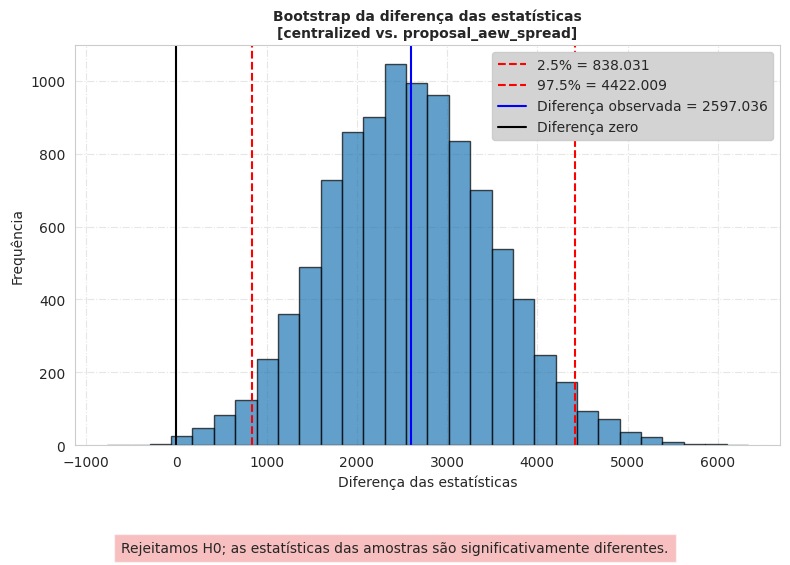

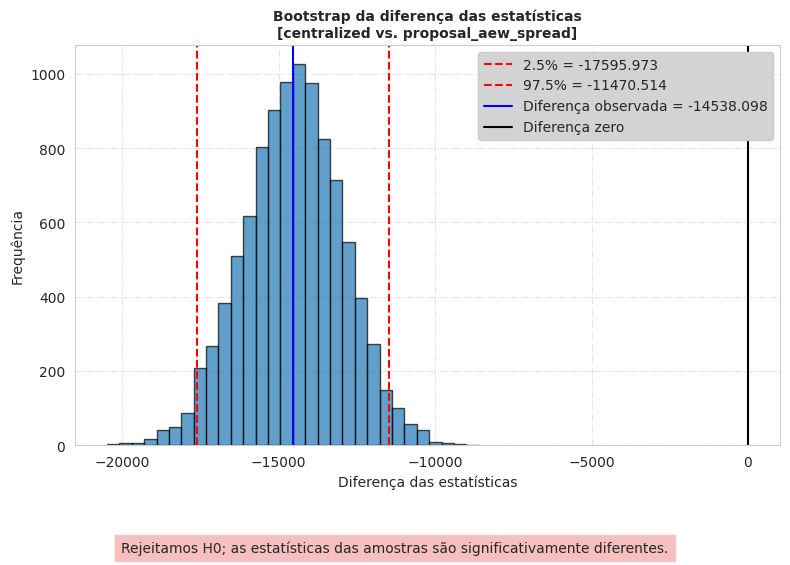

In [28]:
for i in range(len(dataframes)):
    for j in range(i + 1, len(dataframes)):
        data_a = dataframes[i]
        data_b = dataframes[j]
        plot_bootstrap(data_a, data_b, statistic=np.std)  
        plot_bootstrap(data_a, data_b, statistic=np.mean)  